In [1]:
import numpy as np
import pandas as pd
import pickle
import scipy as sp
import shap
import torch

from datasets import Dataset, DatasetDict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold
from tqdm.notebook import trange
from ray import tune
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline, TrainingArguments, Trainer

In [2]:
### YOUR PATH HERE
filepath = '.'

# Import the dataset

In [3]:
df = pd.read_csv(filepath + '/data/second_gen/ratings.csv')[1:].fillna('')
df['labels'] = df.apply(lambda x: x['rating_consensus'] if x['rating_consensus'] != '' else x['rating1'] if ((x['rating1'] == x['rating2']) and (x['consensus_reason'] == '') and (x['rating1'] != '')) else 'error', axis=1)
test_df = df[-800:]
train_val_df = df[:-800]
print('Number of samples in all df: {}, Number of samples in test df: {}, Number of samples in train_val df: {}'.format(len(df),len(test_df), len(train_val_df)))

Number of samples in all df: 3933, Number of samples in test df: 800, Number of samples in train_val df: 3133


In [6]:
train_df, val_df = train_test_split (train_val_df, test_size=0.2)

print('Length of train set: {}'.format(len(train_df)))
print('Length of val set: {}'.format(len(val_df)))
print('Number of included in train set: {} for ratio: {:.3f}'.format(train_df['labels'].sum(), train_df['labels'].sum()/len(train_df)))
print('Number of included in val set: {} for ratio: {:.3f}'.format(val_df['labels'].sum(), val_df['labels'].sum()/len(val_df)))

Length of train set: 2506
Length of val set: 627
Number of included in train set: 181.0 for ratio: 0.072
Number of included in val set: 40.0 for ratio: 0.064


In [7]:
df_columns_to_keep = ['text', 'labels']
train_val_df = train_val_df[df_columns_to_keep]
train_df = train_df[df_columns_to_keep]
val_df = val_df[df_columns_to_keep]
test_df = test_df[df_columns_to_keep]

In [6]:
train_val_ds = Dataset.from_pandas(train_val_df)
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

ds = DatasetDict()
ds['train_val'] = train_val_ds
ds['train'] = train_ds
ds['val'] = val_ds
ds['test'] = test_ds

In [7]:
ds.cleanup_cache_files()
test_ds.cleanup_cache_files()

0

In [8]:
ds = ds.class_encode_column('labels')

Casting the dataset: 100%|██████████| 1/1 [00:00<00:00, 499.74ba/s]


# Model

In [9]:
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')

In [10]:
def tokenizer_function(samples):
    return tokenizer(samples['text'], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

100%|██████████| 1/1 [00:00<00:00,  6.75ba/s]


In [11]:
def compute_single_label_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metrics = {'accuracy':accuracy_score(labels, predictions), 'f1':f1_score(labels, predictions), 'precision':precision_score(labels, predictions), 'recall':recall_score(labels, predictions)}
    return metrics

## HP search

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}
training_args = TrainingArguments(filepath + '/results/inclusion/run1', evaluation_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, local_dir=filepath + '/results/inclusion/run1')

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)

hp_space = {
    'learning_rate':tune.choice([3e-5, 2e-5, 1.2e-5, 1e-5, 8e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,6,8,10]),
    'per_device_train_batch_size':8
}
training_args = TrainingArguments(filepath + '/results/inclusion/run2', evaluation_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, local_dir=filepath + '/results/inclusion/transformers_hp_search/ray')

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)

hp_space = {
    'learning_rate':tune.choice([3e-5, 2e-5, 1.2e-5, 1e-5, 8e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,6,8,10]),
    'per_device_train_batch_size':8
}
training_args = TrainingArguments(filepath + '/results/inclusion/run2', evaluation_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, local_dir=filepath + '/results/inclusion/run2')

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)

hp_space = {
    'learning_rate':tune.choice([1.5e-5, 1.2e-5, 1e-5]),
    'num_train_epochs':tune.choice([10]),
    'per_device_train_batch_size':8
}
training_args = TrainingArguments(filepath + '/results/inclusion/run3', evaluation_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, local_dir=filepath + '/results/inclusion/run3')

### Train test eval model

In [12]:
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)
training_args = TrainingArguments(filepath + '/models/test_set_eval_models/inclusion_biobert', evaluation_strategy='no', logging_strategy='no', learning_rate=1e-5, num_train_epochs=4)
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train_val'])
trainer.train()
trainer.save_model(filepath + '/models/test_set_eval_models/inclusion_biobert/model')

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

{'train_runtime': 631.78, 'train_samples_per_second': 19.836, 'train_steps_per_second': 2.482, 'train_loss': 0.11861412865774972, 'epoch': 4.0}


Model weights saved in ./models/test_set_eval_models/inclusion_biobert/model\pytorch_model.bin


In [13]:
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8
100%|██████████| 100/100 [00:12<00:00,  7.98it/s]


{'eval_loss': 0.13802237808704376,
 'eval_accuracy': 0.965,
 'eval_f1': 0.7543859649122806,
 'eval_precision': 0.7166666666666667,
 'eval_recall': 0.7962962962962963,
 'eval_runtime': 12.7616,
 'eval_samples_per_second': 62.688,
 'eval_steps_per_second': 7.836,
 'epoch': 4.0}

# Determine thresholds to automatically exclude papers
Goal: Recall = 1

In [12]:
all_df = df[df_columns_to_keep]
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}

def tokenizer_function(samples):
    return tokenizer(samples['text'], padding="max_length", truncation=True, max_length=512)

                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
2  Leveraging the pharmacy executive beyond the p...     0.0
3  The utilization of simulated patients for teac...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
                                                 text  labels
7   Pharmacists' Perceptions of Handling Antimicro...     0.0
9   Development and Implementation of In-House Pha...     0.0
13  Implementing a personalized pharmaceutical pla...     0.0
15  Identifying COVID-19 and H1N1 vaccination hesi...     0.0
18  A pharmacist-led intervention to improve the m...     0.0


100%|██████████| 4/4 [00:00<00:00,  6.40ba/s]
loading configuration file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/config.json from cache at C:\Users\maxim/.cache\huggingface\transformers\ece5e89bab3b63a40e413c7f599e6081663cad06eb394e48d5023930733d15a3.ad895c9bc4687ffedea1a4cc498ac3f67ebd2083732981c2a06f548cde7d6582
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/dmis-lab/biobert-base-cas

{'train_runtime': 628.0932, 'train_samples_per_second': 20.035, 'train_steps_per_second': 2.509, 'train_loss': 0.09697672074216271, 'epoch': 4.0}


  0%|          | 0/787 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                text  labels
2  Leveraging the pharmacy executive beyond the p...     0.0
3  The utilization of simulated patients for teac...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
6  Challenges for Polish Community Pharmacists in...     0.0
                                                 text  labels
1   The utility of Conversation Analysis versus Ro...     0.0
8   Metabolic Activation of the Toxic Natural Prod...     0.0
23  Comparison of Interventions Made in an Ambulat...     1.0
26  Determination of the Optimal Procalcitonin Thr...     0.0
32  Utilization of Technology to Improve Efficienc...     0.0


100%|██████████| 4/4 [00:00<00:00,  6.56ba/s]
loading configuration file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/config.json from cache at C:\Users\maxim/.cache\huggingface\transformers\ece5e89bab3b63a40e413c7f599e6081663cad06eb394e48d5023930733d15a3.ad895c9bc4687ffedea1a4cc498ac3f67ebd2083732981c2a06f548cde7d6582
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/dmis-lab/biobert-base-cas

{'train_runtime': 618.9322, 'train_samples_per_second': 20.332, 'train_steps_per_second': 2.546, 'train_loss': 0.09512558564316803, 'epoch': 4.0}


  0%|          | 0/787 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
2  Leveraging the pharmacy executive beyond the p...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
6  Challenges for Polish Community Pharmacists in...     0.0
                                                 text  labels
3   The utilization of simulated patients for teac...     0.0
14  Pharmacists and telemedicine: an innovative mo...     0.0
19  The psychological health of patients diagnosed...     0.0
21  Development and Implementation of Interprofess...     0.0
24  Prescribing of Pressor Agents in Septic Shock:...     0.0


100%|██████████| 4/4 [00:00<00:00,  4.98ba/s]
loading configuration file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/config.json from cache at C:\Users\maxim/.cache\huggingface\transformers\ece5e89bab3b63a40e413c7f599e6081663cad06eb394e48d5023930733d15a3.ad895c9bc4687ffedea1a4cc498ac3f67ebd2083732981c2a06f548cde7d6582
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/dmis-lab/biobert-base-cas

{'train_runtime': 611.9298, 'train_samples_per_second': 20.564, 'train_steps_per_second': 2.575, 'train_loss': 0.10067905871396138, 'epoch': 4.0}


  0%|          | 0/787 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
2  Leveraging the pharmacy executive beyond the p...     0.0
3  The utilization of simulated patients for teac...     0.0
5  Exploration of pharmacist comfort with harm re...     0.0
7  Pharmacists' Perceptions of Handling Antimicro...     0.0
                                                 text  labels
4   Implementing an Antimicrobial Stewardship Prog...     0.0
6   Challenges for Polish Community Pharmacists in...     0.0
10  Pharmacists' perceived role in supporting diab...     0.0
11  A multifaceted approach in leveraging electron...     0.0
16  Economic impact and health care utilization ou...     0.0


100%|██████████| 4/4 [00:00<00:00,  6.09ba/s]
loading configuration file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/config.json from cache at C:\Users\maxim/.cache\huggingface\transformers\ece5e89bab3b63a40e413c7f599e6081663cad06eb394e48d5023930733d15a3.ad895c9bc4687ffedea1a4cc498ac3f67ebd2083732981c2a06f548cde7d6582
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/dmis-lab/biobert-base-cas

{'train_runtime': 618.4718, 'train_samples_per_second': 20.353, 'train_steps_per_second': 2.548, 'train_loss': 0.09861903505276907, 'epoch': 4.0}


  0%|          | 0/786 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                                                text  labels
1  The utility of Conversation Analysis versus Ro...     0.0
3  The utilization of simulated patients for teac...     0.0
4  Implementing an Antimicrobial Stewardship Prog...     0.0
6  Challenges for Polish Community Pharmacists in...     0.0
7  Pharmacists' Perceptions of Handling Antimicro...     0.0
                                                 text  labels
2   Leveraging the pharmacy executive beyond the p...     0.0
5   Exploration of pharmacist comfort with harm re...     0.0
12  Decision coaching for people making healthcare...     0.0
17  Cyclodextrin applications in pharmacy, biology...     0.0
20  Qualitative Investigation of Community Pharmac...     0.0


100%|██████████| 4/4 [00:00<00:00,  6.20ba/s]
loading configuration file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/config.json from cache at C:\Users\maxim/.cache\huggingface\transformers\ece5e89bab3b63a40e413c7f599e6081663cad06eb394e48d5023930733d15a3.ad895c9bc4687ffedea1a4cc498ac3f67ebd2083732981c2a06f548cde7d6582
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/dmis-lab/biobert-base-cas

{'train_runtime': 624.2919, 'train_samples_per_second': 20.164, 'train_steps_per_second': 2.524, 'train_loss': 0.093303438370603, 'epoch': 4.0}


  0%|          | 0/786 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


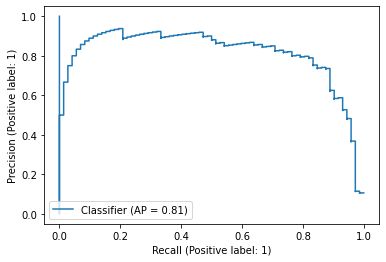

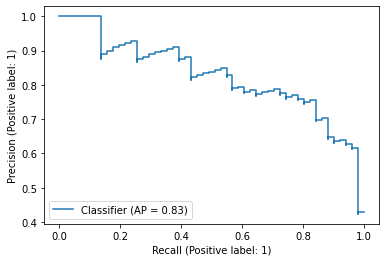

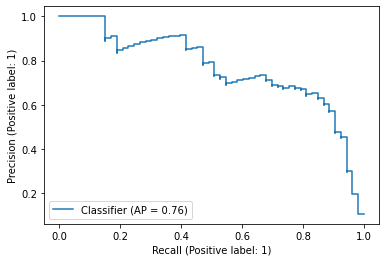

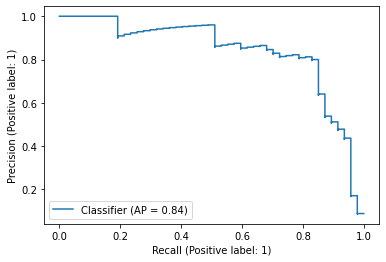

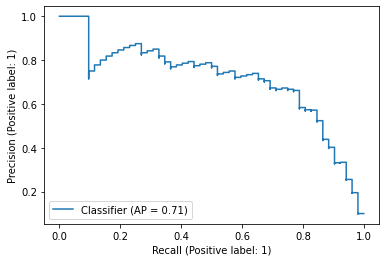

In [27]:
kf = KFold(n_splits=5, shuffle=True)
thresholds = []

for train_idx, val_idx in kf.split(all_df):
    train = all_df.iloc[train_idx]
    print(train.head())
    val = all_df.iloc[val_idx]
    print(val.head())
    ds = Dataset.from_pandas(train)
    ds.cleanup_cache_files()
    ds = ds.class_encode_column('labels')

    tokenized_ds = ds.map(tokenizer_function, batched=True)

    model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)
    training_args = TrainingArguments(filepath + '/.temp', save_strategy='no', evaluation_strategy='no', logging_strategy='no', overwrite_output_dir=True, learning_rate=1e-5, num_train_epochs=4)
    trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_ds)
    trainer.train()

    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=0)
    scores = []
    for i in trange(len(val)):
        scores.append(pipe(val.iloc[i]['text'], **tokenizer_kwargs)[0][1]['score'])

    PrecisionRecallDisplay.from_predictions(val['labels'], scores)

    pr,re,th = precision_recall_curve(val['labels'], scores)
    rth_df = pd.DataFrame.from_dict({'precision':pr[:-1],'recall':re[:-1],'threshold':th})

    ceiling_recall = 0.99
    thresholds.append(rth_df[rth_df.recall >= ceiling_recall].iloc[-1]['threshold'])

In [45]:
thr_df = pd.DataFrame(thresholds)
thr_df

,0
0,0.000171
1,0.000664
2,0.000361
3,0.000224
4,0.000292


In [44]:
threshold = thr_df.mean()[0]
print('Mean threshold: {:.20f}'.format(threshold))
recall_test = []
preds = []
incorrect = []
for i, label, score in zip(range(len(val['labels'])), val['labels'], scores):
    if score >= threshold:
        recall_test.append({'index':i, 'label':label, 'score':score})
        preds.append(1)
    else:
        if label == 1:
            incorrect.append(i)
        preds.append(0)
print('Number of abstracts excluded from review based on recall threshold: {} out of {} for ratio of {:.3f}'.format(len(val) - len(recall_test), len(val), (len(val) - len(recall_test)) / len(val)))
print('Adjusted threshold precision: {:.3f}, recall: {:.3f}, f1: {:.3f}, accuracy: {:.3f}'.format(precision_score(val['labels'], preds), recall_score(val['labels'], preds), f1_score(val['labels'], preds), accuracy_score(val['labels'], preds)))
print('Number of incorrectly excluded abstracts: {}'.format(len(incorrect)))


Mean threshold: 0.00034214244806207716
Number of abstracts excluded from review based on recall threshold: 405 out of 786 for ratio of 0.515
Adjusted threshold precision: 0.134, recall: 0.981, f1: 0.236, accuracy: 0.579
Number of incorrectly excluded abstracts: 1


# Train a production model

In [12]:
all_df = df[df_columns_to_keep]
all_ds = Dataset.from_pandas(all_df)
all_ds.cleanup_cache_files()
all_ds = all_ds.class_encode_column('labels')
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')

def tokenizer_function(samples):
    return tokenizer(samples['text'], padding="max_length", truncation=True, max_length=512)

tokenized_all_ds = all_ds.map(tokenizer_function, batched=True)

100%|██████████| 4/4 [00:00<00:00,  4.87ba/s]


In [13]:
model_version = '1'
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)
training_args = TrainingArguments(filepath + '/models/production_models/inclusion_biobert/v{}'.format(model_version), evaluation_strategy='no', logging_strategy='no', learning_rate=1e-5, num_train_epochs=4)
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_all_ds)
trainer.train()
trainer.save_model(filepath + '/models/production_models/inclusion_biobert/v{}'.format(model_version))

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

{'train_runtime': 772.9723, 'train_samples_per_second': 20.353, 'train_steps_per_second': 2.546, 'train_loss': 0.0873315004798455, 'epoch': 4.0}


Model weights saved in ./models/production_models/inclusion_biobert/v1\pytorch_model.bin
